In [1]:
import pandas as pd
import glob, os 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter('ignore')

---

# Read data

[Dataset location (team drive)](https://drive.google.com/open?id=1vNN8ggAXWOgvHJjjeSzhWn3ffqDePaAy)

In [4]:
path = 'F:\CS_599\social-swear-master\social-swear-master\datasets'

In [ ]:
%%time 
tweets_raw = pd.read_csv(DATASET_LOCATION).drop('Unnamed: 0', axis=1)

In [5]:
%%time

allFiles = glob.glob(path + "/*.csv")
tweets_raw = pd.DataFrame()
sets = [[0,100],[101,200],[201,300],[301,500],[501,800],[801,1000],[1001,1500],[1501,5000],[5001,10000],[10001,999999999999]]
w_set = 9      #change to use different set of data
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    df = df.loc[(df['user_followers_count'] >= sets[w_set][0]) & (df['user_followers_count'] <= sets[w_set][1]) ]
    tweets_raw = pd.concat([tweets_raw,df])
    

Wall time: 3min 36s


In [6]:
len(tweets_raw)

744869

Column descriptions:
- Tweet content:
    -    `text`: raw text of the tweet, unchanged
    -    `text_noMention`': text of the tweet with @mentions removed (='NO_USER_MENTIONS' if 0 mentions)
    -    `numMentions`: number of mentions found in the tweet



- Tweet metadata:
    -    `is_quote_status`: whether the tweet is a quote status of another tweet
    -    `is_reply_to_status`: whether the tweet is a reply to someone elses tweet
    -    `is_reply_to_user`: whether the tweet is a reply to a user


- Account information:
    -    `user_followers_count`: number of followers the user has
    -    `user_friends_count`: number of people the user follows
    -    `user_listed_count`: number of lists the user is a part of
    -    `user_favourites_count`: number of tweets the user has liked to date
    -    `user_statuses_count`: number of tweets this user has authored to date (note that timeline acquisition is limited to 3200 latest tweets)
    -    `user_verified`: whether the user is a verified user
    -    `user_description_text`: raw text of the user's profile description
    


- Engagement:
    -    `retweet_count`: number of times this tweet has been retweeted (at time of collection)
    -    `favorite_coun`': number of times this tweet has been liked (at time of collection)

In the future:
- [ ] date
- [ ] location (from geo-coordinates or timezone)

## Curate dataframe

In [7]:
#Create new column objective with weighted sum of favorite and retweet
tweets_raw['retweet_count']*= 5
tweets_raw['engagment'] = tweets_raw['favorite_count'] + tweets_raw['retweet_count']

In [8]:
tweets = tweets_raw[[
    'user_id',
    'text',
    'retweet_count',
    'favorite_count',
    'user_followers_count',
    'user_friends_count',
    'user_statuses_count',
    'numMentions',
    'engagment'
]].rename({
    'retweet_count': 'n_retweets',
    'favorite_count': 'n_favorites',
    'user_followers_count': 'n_user_followers',
    'user_friends_count': 'n_user_following',
    'user_statuses_count': 'n_user_posts'
}, axis=1)

In [9]:
tweets['is_reply'] = tweets_raw.is_reply_to_user.astype(bool) | tweets_raw.is_reply_to_status.astype(bool)

In [10]:
int_cols = ['n_retweets', 'n_favorites', 'n_user_followers', 'n_user_following', 'n_user_posts']
for col in int_cols:
    tweets[col] = tweets[col].astype(int, errors='ignore')
tweets.dropna(inplace=True)

# Cleanup

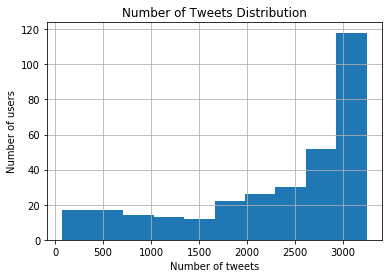

In [12]:
tweets.user_id.value_counts().hist()
plt.title('Number of Tweets Distribution')
plt.ylabel('Number of users')
plt.xlabel('Number of tweets')
plt.show()

In [13]:
f'{tweets.user_id.nunique()} unique users in total'

'321 unique users in total'

## Find spam

In [14]:
import numpy as np

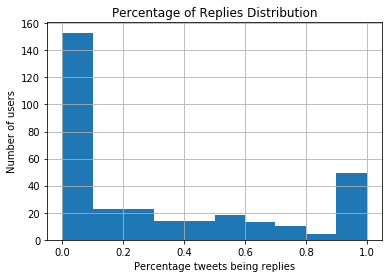

In [15]:
per_replies = tweets.groupby('user_id').is_reply.mean()
per_replies.hist()
plt.title('Percentage of Replies Distribution')
plt.ylabel('Number of users')
plt.xlabel('Percentage tweets being replies')
plt.show()

In [16]:
# no replies (under 1% percent) likely means that the user is a bot
bots_ids = per_replies[per_replies < .01].index
tweets['is_user_bot'] = tweets.user_id.isin(bots_ids)

In [17]:
f'{tweets.is_user_bot.mean():.1%} posts characterized as bots'

'32.7% posts characterized as bots'

## Find outliers

In [18]:
tweets['is_valid'] = ~tweets.is_user_bot #& ~tweets.is_outlier did not use in users over 5001 n_user_followers

In [19]:
valid_tweets = tweets
f'{len(valid_tweets):,} valid tweets'

'744,846 valid tweets'

# Pre-process

In [20]:
#Create Dict of all tweets
tweet_dictionary = {}
i = 0
for line in valid_tweets['text']:
        tweet_dictionary[i] = line.lower()
        i += 1

In [21]:
%%time
#demoji text
import emoji
for i in range(0,len(tweet_dictionary)):
    #print(i)
    tweet_dictionary[i]=emoji.demojize(tweet_dictionary[i])
    #print(i)

Wall time: 3min 28s


In [22]:
%%time
#strip links
import re
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

for i in range(0,len(tweet_dictionary)):
    tweet_dictionary[i]=strip_links(tweet_dictionary[i])

Wall time: 4.03 s


In [23]:
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "i'm": "i am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    text = c_re.sub(replace, text.lower())
    return text

In [24]:
%%time
for i in range(0,len(tweet_dictionary)):
    tweet_dictionary[i]=expandContractions(tweet_dictionary[i])

Wall time: 20.2 s


In [25]:
%%time
#Remove Mentions
import string
def strip_mentions(text):
    entity_prefixes = ['@']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

for i in range(0,len(tweet_dictionary)):
    tweet_dictionary[i]=strip_mentions(tweet_dictionary[i])

Wall time: 9.1 s


In [26]:
%%time
#Remove Hashtags
def strip_hashtags(text):
    entity_prefixes = ['#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

for i in range(0,len(tweet_dictionary)):
    tweet_dictionary[i]=strip_hashtags(tweet_dictionary[i])

Wall time: 8.69 s


In [27]:
%%time
#Remove Special characters
import unicodedata
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

for i in range(0,len(tweet_dictionary)):
    tweet_dictionary[i]=remove_special_characters(tweet_dictionary[i], remove_digits=True)

Wall time: 2.44 s


In [29]:
# Save a processed dict into a pickle file.
import pickle
pickle.dump( tweet_dictionary, open( "tweet_dict_10001_999999.pkl", "wb" ) )

In [30]:
from textblob import TextBlob

In [32]:
%%time
#Text Blob sentiment and obj columns

polarity=[]
subjectivity=[]

for i in range(0,len(tweet_dictionary)):
    snt = TextBlob(tweet_dictionary[i])
    polarity.append(snt.sentiment.polarity)
    subjectivity.append(snt.sentiment.subjectivity)

Wall time: 5min 25s


In [33]:
se = pd.Series(polarity)
valid_tweets['text_polarity'] = se.values
se = pd.Series(subjectivity)
valid_tweets['text_subjectivity'] = se.values

In [34]:
%%time
#Create Vader sentiment columns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

comp=[]
pos=[]
neu=[]
neg=[]
for i in range(0,len(valid_tweets)):
    snt = analyser.polarity_scores(tweet_dictionary[i])
    #print(i)
    #print(tweetData.at[i,'vader_comp'])
    comp.append(snt['compound'])
    pos.append(snt['pos'])
    neu.append(snt['neu'])
    neg.append(snt['neg'])

Wall time: 2min 18s


In [35]:
se = pd.Series(comp)
valid_tweets['vader_comp'] = se.values
se = pd.Series(pos)
valid_tweets['vader_pos'] = se.values
se = pd.Series(neu)
valid_tweets['vader_neu'] = se.values
se = pd.Series(neg)
valid_tweets['vader_neg'] = se.values

In [36]:
#processed tweets to df
se = pd.Series(tweet_dictionary)
valid_tweets['processed_text'] = se.values

In [37]:
# tokenize, lemmatize, lowercase
%time valid_tweets['text_standardized'] = valid_tweets.processed_text.apply(lambda t: TextBlob(t).words.lemmatize())

Wall time: 3min 38s


In the future:
- [ ] un-censor (turn `fck`, `f*ck` and `f%#k` into `fuck`)
- [ ] keep only english language tweets (`TextBlob` has a `detect_language` method)
- [ ] apply spell-checking (`TextBlob` has a `correct` method)
- [ ] just for other features extraction: remove links, mentions, hashtags, retweets, stop-words, retweets

## Extract features

### Text-based

In the future:
 - [ ] topic (from our dataset)
 - [ ] topic (pre-trained)
 - [ ] emotion (categorical or dimensional)
 - [ ] intent (sell/ask/advise — derived from account type?)
 - [ ] POSs
 - [ ] word embedding (sum?)
 - [ ] tf-idf
 - [ ] grammatical correctness (edit distance from corrected version)
 - [ ] descriptions of images, videos
 - [ ] particular punctuation marks
 - [ ] particular emojis
 
More features:
 - [ ] other features listed in the spreadsheet
 - [ ] check out libraries: NLTK, Stanford CoreNLP, SpaCy, Gensim, Vader, LIWC, MPQA, SentiStrength, Vocabulary, PyNLPl, Pattern, sklearn NLP, SyntaxNet, IBM Watson
 - [ ] other libraries presented in October 5th lecture (still not uploaded)

In [38]:
valid_tweets['text_len'] = valid_tweets.text.str.len()

In [39]:
# rudimentary: catches nearly all cases, but can be further refined
valid_tweets['n_mentions'] = valid_tweets.text.str.count('@')
valid_tweets['n_hashtags'] = valid_tweets.text.str.count('#')
valid_tweets['n_links']    = valid_tweets.text.str.count('http')
valid_tweets['n_emojis'] = valid_tweets.text.apply(emoji.emoji_count)

### Swear-word related

In the future:
- [ ] get (a few) more swear words, manually curated
- [ ] assign a severity to each
- [ ] incorporate rarity (?)

Sources: [most popular on facebook](http://www.slate.com/blogs/lexicon_valley/2013/09/11/top_swear_words_most_popular_curse_words_on_facebook.html), [quora question](https://www.quora.com/What-are-common-swear-words-in-English)

In [40]:
# function to count swears per tweet
def countSwears(inputSentence):
    wordTokens = inputSentence.split(' ')
    filteredSentence = []
    for w in wordTokens:
        if w in swearWords:
            filteredSentence.append(w)
    return len(filteredSentence)

In [41]:
# Store swear words
f = open('swearWords.txt', 'r+')
swearWords = [line.strip() for line in f.readlines()]
f.close()

swear_tweets = 0
nonswear_tweets = 0
presenceList = []
countList = []
# preprocess tweets (makes a copy of the 'text' field, does not preprocess tweetData['text'])
for i in range(0,len(valid_tweets)):
    count = countSwears(tweet_dictionary[i])
    countList.append(count)
    if count == 0:
        presenceList.append(0)
        nonswear_tweets += 1
    else:
        presenceList.append(1)
        swear_tweets += 1
countList = pd.Series(countList)
presenceList = pd.Series(presenceList)

valid_tweets['swear_count'] = countList.values
valid_tweets['swear_present'] = presenceList.values

In [42]:
f'{valid_tweets[valid_tweets.is_valid].swear_present.mean():.2%} of the tweets contain swear words'

'2.08% of the tweets contain swear words'

Most posts (that contain swear words) have only one swear word, a few of them have two

### Date-related

In [ ]:
"""
from dateutil.parser import parse as parse_date

# parse dates
%time tweets.date = tweets.date.apply(parse_date)

%time tweets['day_of_week'] = tweets.date.apply(lambda d: int(d.strftime('%w')))

%time tweets['hour_of_day'] = tweets.date.apply(lambda d: int(d.strftime('%H')))
"""

## Save File

In [43]:
%time valid_tweets.to_csv('15M_10000_99999999.csv', index=False)

Wall time: 25.5 s
